<a href="https://cognitiveclass.ai"><img src = "https://www.parkia.es/wp-content/uploads/2018/01/bilbo-8.jpg" width = 100% align="center"> </a>

<h1 align=center><font size = 5>Bilbao market research demographic analysis</font></h1>

## Introduction

In this section of the capstone project we are going to try to analyse the existing businesses in the city of Bilbao, located to the north of Spain in the autonomous community of the Basque country.

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

<font size = 3>

1. <a href="#item1">Introduction to the problem</a>

2. <a href="#item2">Methodology</a>

3. <a href="#item3">Explore Neighborhoods</a>

4. <a href="#item4">Cluster Neighborhoods</a>

5. <a href="#item5">Examine Clusters</a>    

</font>
</div>

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /Users/DinocoM/anaconda3

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    certifi-2019.6.16          |           py37_0         148 KB  conda-forge
    conda-4.7.10               |           py37_0         3.0 MB  conda-forge
    geographiclib-1.49         |             py_0          32 KB  conda-forge
    geopy-1.20.0               |             py_0          57 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.49-py_0
  geopy              conda-forge/noarch::geopy-1.20.0-py_0

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi                       

<a id='item1'></a>

## 1. Introduction to the problem

Every analysis should start with a problem to be solved, so we will raise an assumption and from it and with the tools we have, we will try to reach conclusions that help to solve the problem or help Make the right decisions.

Let's imagine that there is a group of investors who plan to open a business in Bilbao, they are not clear about the business idea, so they want to analyze the offer of leisure and services in the metropolitan area of Bilbao that has a greater population, since it is going to be an activity at street level facing the public. They want it to also be a business that is destined for the population sector with the greatest representation in the city.

Based on this assumption and with the data we have available, the ultimate goal is to make a recommendation to investors, which meets the previously established requirements.

## 2. Methodology

The first step is to collect relevant data that will help us analyze the problem. demographic data of the city will be needed, with the population divided into ages or at least age ranges. The Bilbao city council makes available to anyone who wants to consult the data related to the demography of the capital of Biscay, which we will use as a starting point for the required demographic study. The public website is Bilbao Open Data.

If you want to consider the fact of exposing this data in a more visual representation such as a map, you must have a division of the population into districts or neighborhoods. Likewise, a geojson map with the city divisions can be very valuable when it comes to treating such data and presenting them in a friendly way, as well as the most representative geographical coordinates. Fortunately, there is a community, Bilbao Data Lab, that has generated a geojson with the different districts of the city of Bilbao to generate maps of school zoning, which will be used to geolocate our own data. This file will be obtained from their public Github repository.

There is also a part in which the most representative businesses in the area with the largest population should be analyzed, so a way to obtain this data must be found. One solution may be the Foursquare public API, with which we can obtain the most representative businesses given a location.

#### Retrieving the data

First of all, lets obtain Bilbao's Coordinates:

##### Use geopy library to get the latitude and longitude values of Bilbao City.

In [2]:
address = 'Bilbao'

geolocator = Nominatim(user_agent="bio_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Bilbao are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Bilbao are 43.2630051, -2.9349915.


Bilbao has a total of 8 boroughs and 40 neighborhoods. In order to segment the neighborhoods and explore them, we will essentially need a dataset that contains the 8 boroughs and the neighborhoods that exist in each borough as well as the the latitude and logitude coordinates of each neighborhood. 

Luckily, this dataset exists for free on the web. We can obtain it throough the Bilbao official website on his Open Data section, here is its URL: https://www.bilbao.eus/opendata/es/inicio

We will manage these data later, there is a lot of information on he website.

Also, in order to show the data in a more graphical way, we would also need a map with the divisions between boroughs of the city of Bilbao, this way we will be able to show densities in a choropleth map.
These divisions can be found in the public repository of github property of BilbaoDataLab, in a geojson file.
The map with the divisions will look as follows, colours shown are based on the borough ID:

In [3]:
# prepare de geojson data of Bilbao to display a choropleth map of its districts
with open('distritos-bilbao.json') as json_data:
    bilbao_data = json.load(json_data)
    
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude', 'Count'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

# Notice how all the relevant data is in the *features* key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.
bilbao_data = bilbao_data['features']

for data in bilbao_data:
    borough = data['properties']['distrito'] 
    neighborhood_name = data['properties']['BAR_DS_O']
        
    neighborhood_latlon = data['geometry']['coordinates'][0][0][0]
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon,
                                         'Count': borough}, ignore_index=True)
    
neighborhoods['Borough'] = neighborhoods['Count']

# Create the map with boroughs coloured

bio_geo = r'distritos-bilbao.json' # geojson file

# create a plain Bio map
bio_map = folium.Map(location=[latitude, longitude], zoom_start = 13)

# generate choropleth map
bio_map.choropleth(
    geo_data=bio_geo,
    data=neighborhoods,
    columns=['Borough', 'Count'],
    key_on='feature.properties.distrito',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Boroughs in Bilbao City by BorughID',
    reset=True
)

# display map
bio_map

#### Load and explore the data from Bilbao OpenData

Next, let's load the data.

Let's take a quick look at the data.

#### Tranform the data into a *pandas* dataframe

The next task is essentially transforming this data of nested Python dictionaries into a *pandas* dataframe. So let's start by creating an empty dataframe.

In [4]:
df_bio = pd.read_csv('Bilbao_population.csv',  encoding = "ISO-8859-1", sep=';')

In [5]:
df_bio.head()

FEC_OFI_AYTO  COD. DISTR.                   DISTRITO  COD. BARRIO  \
0   01/01/2018          1.0  DEUSTU                           101.0   
1   01/01/2018          1.0  DEUSTU                           101.0   
2   01/01/2018          1.0  DEUSTU                           102.0   
3   01/01/2018          1.0  DEUSTU                           102.0   
4   01/01/2018          1.0  DEUSTU                           103.0   

                      BARRIO    Latitud  Longitud     SEXO   0   1   2   3  \
0  SAN IGNACIO                43.281709 -2.962711  HOMBRES  47  46  48  58   
1  SAN IGNACIO                43.281709 -2.962711  MUJERES  47  47  35  54   
2  ELORRIETA                  43.282791 -2.965837  HOMBRES   2   6   7   6   
3  ELORRIETA                  43.282791 -2.965837  MUJERES   7   6   1   4   
4  IBARREKOLANDA              43.274479 -2.958697  HOMBRES  32  32  25  33   

    4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  \
0  55  59  55  45  57  70  55  56  61  70  57  62  70  65  57  61  48  46  54   
1  65  42  52  46  34  53  52  37  57  60  59  63  56  64  53  45  65  58  52   
2   7   9   8   4  12  11   8  12   7   7   6   5   9   9   9   7   8  14   4   
3   5   2  11   7   9  11   2  14   7   8   7  12   6   7   3   8   5   5   5   
4  30  32  29  30  37  36  35  24  39  43  33  38  29  49  42  41  35  40  54   

   23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  \
0  43  57  57  56  69  43  52  58  57  84  58  70  66  59  70  82  85  90  93   
1  52  50  62  51  61  54  61  39  68  56  73  77  72  78  90  90  80  92  85   
2   5   4   7   1   7   6   5   4   4   5   5   2   2   4   7   4   9  14   7   
3   3   5   7   4   4   1   4   5   4   5   8   7   8   6   8   8  11  11  15   
4  34  51  43  49  56  51  66  71  43  61  74  62  62  58  50  73  56  59  71   

   42  43   44   45   46   47   48   49   50   51   52   53   54   55   56  \
0  93  78   88   96   90  111   90  108  109  102  127  134  106  100   99   
1  98  90  107  102  100  106  119  109  128  133  112  121  109  117  101   
2   7   9   11   20   14    9   16   16   12   16   21   15   15   12    8   
3  11  16    6   22   15   14   17   20   18   14   16    8   12    9   15   
4  63  54   68   56   56   49   65   53   67   70   81   78   72   85   76   

    57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  \
0   87  93  91  83  63  66  72  70  64  59  59  42  60  47  30  49  41  36   
1  101  97  97  80  85  71  78  68  74  69  64  72  65  61  67  54  68  63   
2   15   7  11   7  10  10   9   9   8   5   4   5   3   5   4   4   7   4   
3   12  11  13  20   8   3  14   6   7   4   6   5   5   2   7   4   2   2   
4   63  87  79  82  74  95  75  85  84  78  61  78  63  60  72  66  52  49   

   75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
0  35  30  40  25  46  42  38  62  51  48  39  31  21  21  15  19  17   8   6   
1  69  65  73  45  69  74  99  81  67  84  69  59  58  47  48  41  47  37  26   
2   2   3   1   2   1   4   0   2   2   3   0   0   0   1   0   0   0   1   0   
3   1   3   5   0   2   3   5   3   3   4   5   4   5   3   0   0   1   0   0   
4  46  33  30  37  30  48  40  43  34  48  37  27  27  17  19   5  12   7   8   

   94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  \
0   8   4   2   0   0   1    0    0    0    0    0    0    0    0    0    0   
1  24  15  11   8   6   2    2    1    2    0    1    0    2    0    0    0   
2   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0   
3   0   0   0   0   0   1    0    0    0    0    0    0    0    0    0    0   
4   1   2   0   1   1   2    0    0    0    0    0    0    0    0    0    0   

   110  111  TOTAL  
0    0    0   5803  
1    0    0   6705  
2    0    0    629  
3    0    0    668  
4    0    0   4759

There are some rows with NaN values, let's drop them to clean up the data

In [6]:
df_bio = df_bio.dropna()

ahora quitamos las columnas sobrantes y renombramos las columnas al ingles

In [7]:
df_bio = df_bio.drop(['FEC_OFI_AYTO'], axis=1)

# Rename key columns
df_bio = df_bio.rename(columns={"COD. DISTR.": "BoroughId", "DISTRITO": "Borough", "COD. BARRIO": "NeigborhoodId", "BARRIO": "Neighborhood", "Latitud": "Latitude", "Longitud": "Longitude", "SEXO": "Genre"})

And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [8]:
df_bio.head()

BoroughId                    Borough  NeigborhoodId  \
0        1.0  DEUSTU                             101.0   
1        1.0  DEUSTU                             101.0   
2        1.0  DEUSTU                             102.0   
3        1.0  DEUSTU                             102.0   
4        1.0  DEUSTU                             103.0   

                Neighborhood   Latitude  Longitude    Genre   0   1   2   3  \
0  SAN IGNACIO                43.281709  -2.962711  HOMBRES  47  46  48  58   
1  SAN IGNACIO                43.281709  -2.962711  MUJERES  47  47  35  54   
2  ELORRIETA                  43.282791  -2.965837  HOMBRES   2   6   7   6   
3  ELORRIETA                  43.282791  -2.965837  MUJERES   7   6   1   4   
4  IBARREKOLANDA              43.274479  -2.958697  HOMBRES  32  32  25  33   

    4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  \
0  55  59  55  45  57  70  55  56  61  70  57  62  70  65  57  61  48  46  54   
1  65  42  52  46  34  53  52  37  57  60  59  63  56  64  53  45  65  58  52   
2   7   9   8   4  12  11   8  12   7   7   6   5   9   9   9   7   8  14   4   
3   5   2  11   7   9  11   2  14   7   8   7  12   6   7   3   8   5   5   5   
4  30  32  29  30  37  36  35  24  39  43  33  38  29  49  42  41  35  40  54   

   23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  \
0  43  57  57  56  69  43  52  58  57  84  58  70  66  59  70  82  85  90  93   
1  52  50  62  51  61  54  61  39  68  56  73  77  72  78  90  90  80  92  85   
2   5   4   7   1   7   6   5   4   4   5   5   2   2   4   7   4   9  14   7   
3   3   5   7   4   4   1   4   5   4   5   8   7   8   6   8   8  11  11  15   
4  34  51  43  49  56  51  66  71  43  61  74  62  62  58  50  73  56  59  71   

   42  43   44   45   46   47   48   49   50   51   52   53   54   55   56  \
0  93  78   88   96   90  111   90  108  109  102  127  134  106  100   99   
1  98  90  107  102  100  106  119  109  128  133  112  121  109  117  101   
2   7   9   11   20   14    9   16   16   12   16   21   15   15   12    8   
3  11  16    6   22   15   14   17   20   18   14   16    8   12    9   15   
4  63  54   68   56   56   49   65   53   67   70   81   78   72   85   76   

    57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  \
0   87  93  91  83  63  66  72  70  64  59  59  42  60  47  30  49  41  36   
1  101  97  97  80  85  71  78  68  74  69  64  72  65  61  67  54  68  63   
2   15   7  11   7  10  10   9   9   8   5   4   5   3   5   4   4   7   4   
3   12  11  13  20   8   3  14   6   7   4   6   5   5   2   7   4   2   2   
4   63  87  79  82  74  95  75  85  84  78  61  78  63  60  72  66  52  49   

   75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93  \
0  35  30  40  25  46  42  38  62  51  48  39  31  21  21  15  19  17   8   6   
1  69  65  73  45  69  74  99  81  67  84  69  59  58  47  48  41  47  37  26   
2   2   3   1   2   1   4   0   2   2   3   0   0   0   1   0   0   0   1   0   
3   1   3   5   0   2   3   5   3   3   4   5   4   5   3   0   0   1   0   0   
4  46  33  30  37  30  48  40  43  34  48  37  27  27  17  19   5  12   7   8   

   94  95  96  97  98  99  100  101  102  103  104  105  106  107  108  109  \
0   8   4   2   0   0   1    0    0    0    0    0    0    0    0    0    0   
1  24  15  11   8   6   2    2    1    2    0    1    0    2    0    0    0   
2   0   0   0   0   0   0    0    0    0    0    0    0    0    0    0    0   
3   0   0   0   0   0   1    0    0    0    0    0    0    0    0    0    0   
4   1   2   0   1   1   2    0    0    0    0    0    0    0    0    0    0   

   110  111  TOTAL  
0    0    0   5803  
1    0    0   6705  
2    0    0    629  
3    0    0    668  
4    0    0   4759

generamos un nuevo dataframe que no distinga por sexo

In [9]:
# finally, let's create a list of years from 1980 - 2013
# this will come in handy when we start plotting the data
years = list(map(str, range(0, 112)))

In [55]:
#df_bio2 = df_bio.groupby(['BoroughId', 'Borough', 'NeigborhoodId', 'Neighborhood', 'Latitude', 'Longitude']).agg('sum')
df_bio2 = df_bio.groupby(['Borough']).agg('sum')

df_bio2 = df_bio2.drop(['BoroughId', 'NeigborhoodId','Latitude','Longitude', 'TOTAL'], axis=1)
df_bio2.head()

# transpose the dataframe
df_bio2 = df_bio2[years].transpose() 

# Transform index in integer for visualization
df_bio2.index = df_bio2.index.map(int)

df_bio2.head(32)

Borough  ABANDO                     BASURTU-ZORROTZA           \
30                             522                        405   
31                             530                        442   
32                             552                        447   
33                             499                        458   
34                             543                        470   
35                             608                        450   
36                             545                        489   
37                             651                        457   
38                             630                        454   
39                             642                        467   
40                             626                        439   
41                             669                        474   
42                             658                        474   
43                             756                        457   
44                             703                        483   
45                             718                        463   
46                             732                        464   
47                             751                        516   
48                             728                        505   
49                             728                        487   
50                             799                        473   
51                             803                        501   
52                             774                        525   
53                             855                        511   
54                             902                        501   
55                             850                        511   
56                             832                        520   
57                             871                        550   
58                             873                        529   
59                             792                        515   
60                             820                        566   

Borough  BEGOÑA                     DEUSTU                     \
30                             402                        540   
31                             402                        543   
32                             415                        551   
33                             462                        598   
34                             475                        610   
35                             449                        557   
36                             491                        558   
37                             477                        546   
38                             579                        613   
39                             602                        635   
40                             592                        660   
41                             608                        646   
42                             643                        677   
43                             653                        653   
44                             581                        636   
45                             598                        707   
46                             637                        661   
47                             615                        685   
48                             607                        724   
49                             608                        713   
50                             672                        752   
51                             597                        790   
52                             612                        823   
53                             631                        869   
54                             627                        785   
55                             617                        777   
56                             625                        755   
57                             537                        811   
58                             580

In [11]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.1.0


Text(0.5, 0, 'Age')

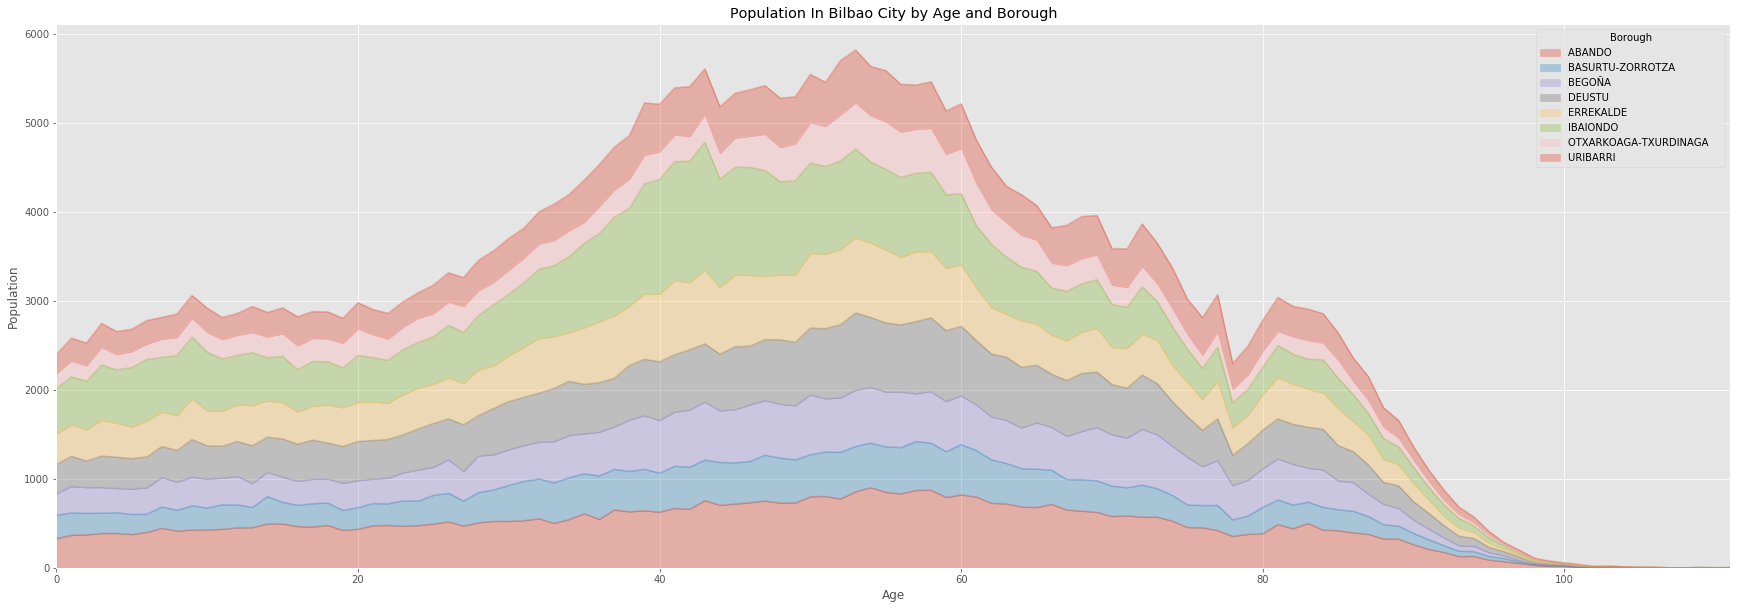

In [12]:
# Show the data in area plot
ax = df_bio2.plot(kind='area', alpha=0.35, figsize=(30, 10))

ax.set_title('Population In Bilbao City by Age and Borough')
ax.set_ylabel('Population')
ax.set_xlabel('Age')

In [13]:
years = list(map(str, range(30, 61)))

In [14]:
df_bio2 = df_bio.groupby(['Borough']).agg('sum')

df_bio2 = df_bio2.drop(['BoroughId', 'NeigborhoodId','Latitude','Longitude', 'TOTAL'], axis=1)
df_bio2.head()

# transpose the dataframe
df_bio2 = df_bio2[years].transpose() 

# Transform index in integer for visualization
df_bio2.index = df_bio2.index.map(int)

df_bio2.head()

Borough  ABANDO                     BASURTU-ZORROTZA           \
30                             522                        405   
31                             530                        442   
32                             552                        447   
33                             499                        458   
34                             543                        470   

Borough  BEGOÑA                     DEUSTU                     \
30                             402                        540   
31                             402                        543   
32                             415                        551   
33                             462                        598   
34                             475                        610   

Borough  ERREKALDE                  IBAIONDO                   \
30                             516                        693   
31                             564                        725   
32                             613                        780   
33                             584                        798   
34                             547                        852   

Borough  OTXARKOAGA-TXURDINAGA      URIBARRI                   
30                             269                        358  
31                             278                        336  
32                             284                        362  
33                             282                        410  
34                             296                        406

Text(0.5, 0, 'Age')

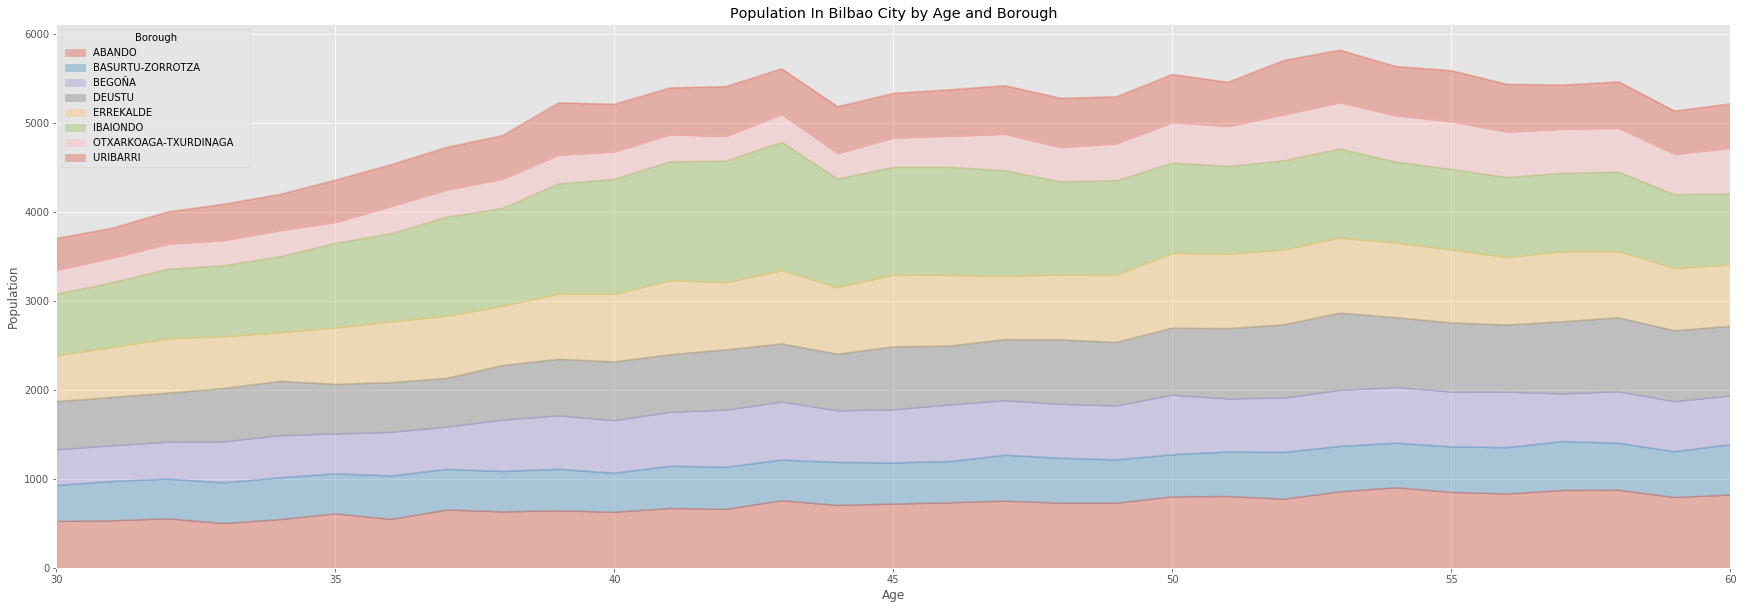

In [15]:
# Show the data in area plot
ax = df_bio2.plot(kind='area', alpha=0.35, figsize=(30, 10))

ax.set_title('Population In Bilbao City by Age and Borough')
ax.set_ylabel('Population')
ax.set_xlabel('Age')

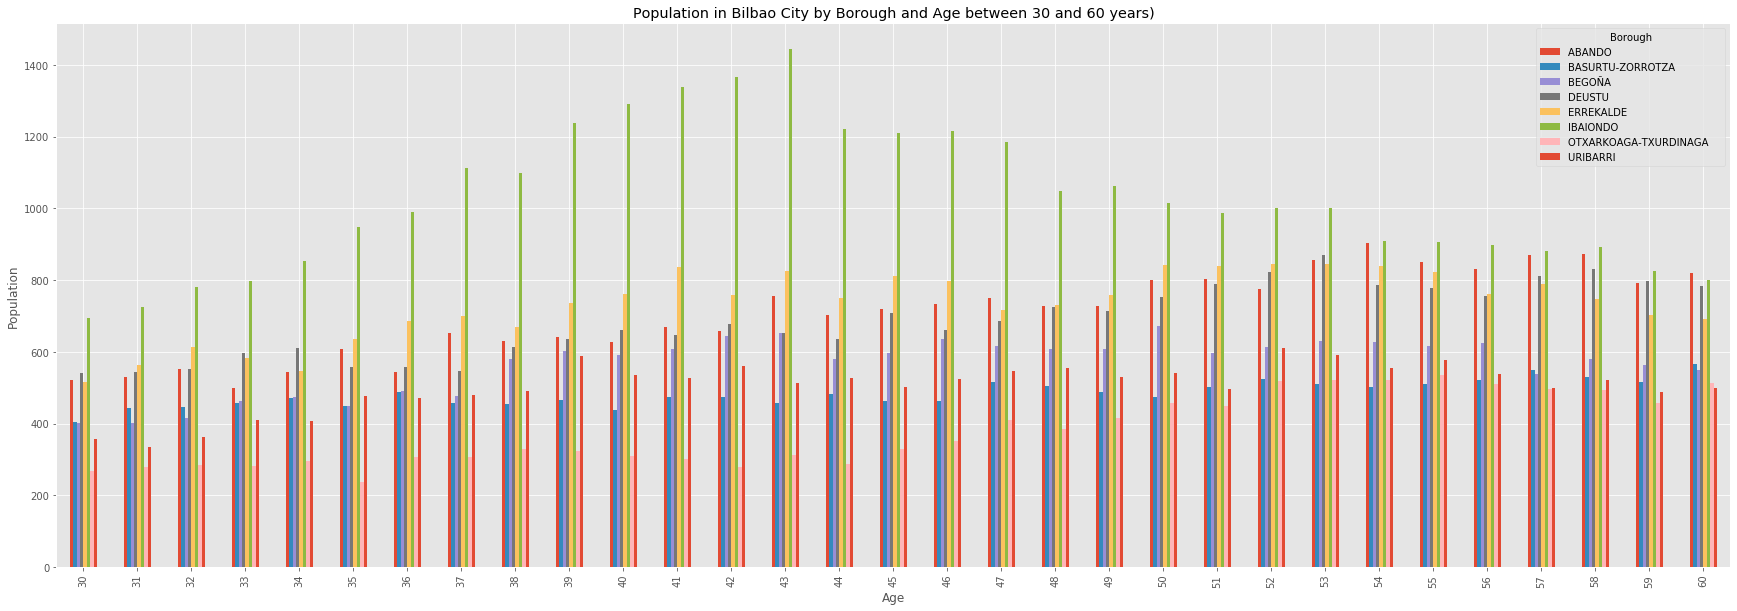

In [16]:
df_bio2.plot(kind='bar', figsize=(30, 10))

plt.xlabel('Age') # add to x-label to the plot
plt.ylabel('Population') # add y-label to the plot
plt.title('Population in Bilbao City by Borough and Age between 30 and 60 years)') # add title to the plot

plt.show()

In [17]:
df_bio_total = df_bio[['Borough', 'TOTAL']].copy()
df_aux = df_bio.drop_duplicates(subset=['BoroughId'])
df_aux = df_aux[['Borough', 'BoroughId']].copy()

df_bio_total = df_bio_total.groupby(['Borough']).agg('sum')

df_bio_total = df_bio_total.reset_index()

df_bio_total = pd.merge(df_bio_total, df_aux, on='Borough')

df_bio_total.head()

Borough  TOTAL  BoroughId
0  ABANDO                     51622        6.0
1  BASURTU-ZORROTZA           32309        8.0
2  BEGOÑA                     40522        4.0
3  DEUSTU                     49060        1.0
4  ERREKALDE                  48178        7.0

In [18]:
# create a plain Bio map
bio_map = folium.Map(location=[latitude, longitude], zoom_start = 13)

# generate choropleth map
bio_map.choropleth(
    geo_data=bio_geo,
    data=df_bio_total,
    columns=['BoroughId', 'TOTAL'],
    key_on='feature.properties.distrito',
    fill_color='YlOrRd', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in Bilbao City by Borough',
    reset=True
)

# display map
bio_map

#### Create a map of Bilbao with neighborhoods superimposed on top.

In [19]:
# new dataframe only with the neighborhoods of Ibaiondo
df_iba = df_bio.loc[df_bio['BoroughId'] == 5]

df_iba = df_iba[['Borough', 'Neighborhood', 'Latitude', 'Longitude']]

In [20]:
# dropping ALL duplicte values 
df_iba.drop_duplicates(subset ="Neighborhood", keep = 'first', inplace = True) 

In [21]:
df_iba.head()

Borough               Neighborhood   Latitude  Longitude
40  IBAIONDO                   CASCO VIEJO                43.257222  -2.923889
42  IBAIONDO                   ITURRALDE                  43.257413  -2.917578
44  IBAIONDO                   SOLOKOETXE                 43.256323  -2.919650
46  IBAIONDO                   ATXURI                     43.253842  -2.921635
48  IBAIONDO                   LA PEÑA                    43.245250  -2.924654

In [52]:
# create map of Bilbao using latitude and longitude values
map_bilbao = folium.Map(location=[latitude, longitude], zoom_start=14)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_iba['Latitude'], df_iba['Longitude'], df_iba['Borough'], df_iba['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=8,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_bilbao)  
    
map_bilbao

Next, we are going to start utilizing the Foursquare API to explore the neighborhoods and segment them.

#### Define Foursquare Credentials and Version

In [23]:
CLIENT_ID = '' # your Foursquare ID -- this is a secret!
CLIENT_SECRET = '' # your Foursquare Secret -- this is a secret!!
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: KAAYALWOPMBKSX4TRZGEPFEEZ1VLQIPFPKDOF11TCCYLMKNV
CLIENT_SECRET:S1YP5BECNI3JMFZGEUV15OETXZL4KYRRU5WIA5SSKVMAPP5P


#### Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [24]:
df_iba = df_iba.reset_index()

df_iba.loc[0, 'Neighborhood']

'CASCO VIEJO              '

Get the neighborhood's latitude and longitude values.

In [25]:
neighborhood_latitude = df_iba.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = df_iba.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = df_iba.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of CASCO VIEJO               are 43.257222, -2.923889.


#### Now, let's get the top 100 venues that are in Ibaiondo within a radius of 500 meters.

First, let's create the GET request URL. Name your URL **url**.

In [26]:
# type your answer here

LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL



'https://api.foursquare.com/v2/venues/explore?&client_id=KAAYALWOPMBKSX4TRZGEPFEEZ1VLQIPFPKDOF11TCCYLMKNV&client_secret=S1YP5BECNI3JMFZGEUV15OETXZL4KYRRU5WIA5SSKVMAPP5P&v=20180605&ll=43.257222,-2.923889&radius=500&limit=100'

Send the GET request and examine the resutls

In [27]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5d498affe0c0c90038375299'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'Casco Viejo',
  'headerFullLocation': 'Casco Viejo, Bilbao',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 69,
  'suggestedBounds': {'ne': {'lat': 43.2617220045, 'lng': -2.917721627400428},
   'sw': {'lat': 43.252721995499996, 'lng': -2.930056372599572}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '55487fa4498e72b2414cb304',
       'name': 'Baster',
       'location': {'address': 'Calle Correo 22',
        'lat': 43.257584703023575,
        'lng': -2.9235431393757607,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.2575847030235

From the Foursquare lab in the previous module, we know that all the information is in the *items* key. Before we proceed, let's borrow the **get_category_type** function from the Foursquare lab.

In [28]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [29]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name        categories        lat       lng
0                     Baster  Tapas Restaurant  43.257585 -2.923543
1       Mercado de La Ribera    Farmers Market  43.255585 -2.924666
2  La Catedral de la Cerveza        Beer Store  43.256252 -2.924831
3                       Gatz               Bar  43.258245 -2.925949
4           Restaurante Mina        Restaurant  43.255256 -2.924382

And how many venues were returned by Foursquare?

In [30]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

69 venues were returned by Foursquare.


## 3. Explore Neighborhoods

#### Let's create a function to repeat the same process to all the neighborhoods in Bilbao

In [31]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called *bilbao_venues*.

In [32]:
# type your answer here

bilbao_venues = getNearbyVenues(names=df_iba['Neighborhood'],
                                   latitudes=df_iba['Latitude'],
                                   longitudes=df_iba['Longitude']
                                  )



CASCO VIEJO              
ITURRALDE                
SOLOKOETXE               
ATXURI                   
LA PEÑA                  
BILBAO LA VIEJA          
SAN FRANCISCO            
ZABALA                   
SAN ADRIAN               
MIRIBILLA                


#### Let's check the size of the resulting dataframe

In [33]:
print(bilbao_venues.shape)
bilbao_venues.head()

(379, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  CASCO VIEJO                            43.257222               -2.923889   
1  CASCO VIEJO                            43.257222               -2.923889   
2  CASCO VIEJO                            43.257222               -2.923889   
3  CASCO VIEJO                            43.257222               -2.923889   
4  CASCO VIEJO                            43.257222               -2.923889   

                       Venue  Venue Latitude  Venue Longitude  \
0                     Baster       43.257585        -2.923543   
1       Mercado de La Ribera       43.255585        -2.924666   
2  La Catedral de la Cerveza       43.256252        -2.924831   
3                       Gatz       43.258245        -2.925949   
4           Restaurante Mina       43.255256        -2.924382   

     Venue Category  
0  Tapas Restaurant  
1    Farmers Market  
2        Beer Store  
3               Bar  
4        Restaurant

Let's check how many venues were returned for each neighborhood

In [34]:
bilbao_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  \
Neighborhood                                                               
ATXURI                                        55                      55   
BILBAO LA VIEJA                               53                      53   
CASCO VIEJO                                   69                      69   
ITURRALDE                                     26                      26   
LA PEÑA                                        5                       5   
MIRIBILLA                                     15                      15   
SAN ADRIAN                                    11                      11   
SAN FRANCISCO                                 80                      80   
SOLOKOETXE                                    41                      41   
ZABALA                                        24                      24   

                           Venue  Venue Latitude  Venue Longitude  \
Neighborhood                                                        
ATXURI                        55              55               55   
BILBAO LA VIEJA               53              53               53   
CASCO VIEJO                   69              69               69   
ITURRALDE                     26              26               26   
LA PEÑA                        5               5                5   
MIRIBILLA                     15              15               15   
SAN ADRIAN                    11              11               11   
SAN FRANCISCO                 80              80               80   
SOLOKOETXE                    41              41               41   
ZABALA                        24              24               24   

                           Venue Category  
Neighborhood                               
ATXURI                                 55  
BILBAO LA VIEJA                        53  
CASCO VIEJO                            69  
ITURRALDE                              26  
LA PEÑA                                 5  
MIRIBILLA                              15  
SAN ADRIAN                             11  
SAN FRANCISCO                          80  
SOLOKOETXE                             41  
ZABALA                                 24

#### Let's find out how many unique categories can be curated from all the returned venues

In [35]:
print('There are {} uniques categories.'.format(len(bilbao_venues['Venue Category'].unique())))

There are 70 uniques categories.


<a id='item3'></a>

## 3. Analyze Each Neighborhood

In [36]:
# one hot encoding
bilbao_onehot = pd.get_dummies(bilbao_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bilbao_onehot['Neighborhood'] = bilbao_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [bilbao_onehot.columns[-1]] + list(bilbao_onehot.columns[:-1])
bilbao_onehot = bilbao_onehot[fixed_columns]

bilbao_onehot.head()

Neighborhood  Art Museum  Asian Restaurant  Bakery  Bar  \
0  CASCO VIEJO                         0                 0       0    0   
1  CASCO VIEJO                         0                 0       0    0   
2  CASCO VIEJO                         0                 0       0    0   
3  CASCO VIEJO                         0                 0       0    1   
4  CASCO VIEJO                         0                 0       0    0   

   Basketball Stadium  Beer Bar  Beer Store  Bistro  Bookstore  \
0                   0         0           0       0          0   
1                   0         0           0       0          0   
2                   0         0           1       0          0   
3                   0         0           0       0          0   
4                   0         0           0       0          0   

   Breakfast Spot  Burger Joint  Burrito Place  Café  Chinese Restaurant  \
0               0             0              0     0                   0   
1               0             0              0     0                   0   
2               0             0              0     0                   0   
3               0             0              0     0                   0   
4               0             0              0     0                   0   

   Clothing Store  Cocktail Bar  Coffee Shop  Deli / Bodega  Dessert Shop  \
0               0             0            0              0             0   
1               0             0            0              0             0   
2               0             0            0              0             0   
3               0             0            0              0             0   
4               0             0            0              0             0   

   Diner  Dog Run  Farmers Market  Flea Market  Food & Drink Shop  \
0      0        0               0            0                  0   
1      0        0               1            0                  0   
2      0        0               0            0                  0   
3      0        0               0            0                  0   
4      0        0               0            0                  0   

   Fried Chicken Joint  Garden  Gastropub  Gay Bar  Grilled Meat Restaurant  \
0                    0       0          0        0                        0   
1                    0       0          0        0                        0   
2                    0       0          0        0                        0   
3                    0       0          0        0                        0   
4                    0       0          0        0                        0   

   Grocery Store  Gym  Gym / Fitness Center  Gym Pool  History Museum  \
0              0    0                     0         0               0   
1              0    0                     0         0               0   
2              0    0                     0         0               0   
3              0    0                     0         0               0   
4              0    0                     0         0               0   

   Hobby Shop  Hostel  Hotel  Ice Cream Shop  Italian Restaurant  \
0           0       0      0               0                   0   
1           0       0      0               0                   0   
2           0       0      0               0                   0   
3           0       0      0               0                   0   
4           0       0      0               0                   0   

   Japanese Restaurant  Light Rail Station  Mexican Restaurant  \
0                    0                   0                   0   
1                    0                   0                   0   
2                    0                   0                   0   
3                    0                   0                   0   
4                    0                   0                   0   

   Modern European Restaurant  Moroccan Restaurant  Paella Restaurant  Park  \
0                           0     

And let's examine the new dataframe size.

In [37]:
bilbao_onehot.shape

(379, 71)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [38]:
bilbao_grouped = bilbao_onehot.groupby('Neighborhood').mean().reset_index()
bilbao_grouped

Neighborhood  Art Museum  Asian Restaurant    Bakery  \
0  ATXURI                       0.000000            0.0000  0.018182   
1  BILBAO LA VIEJA              0.018868            0.0000  0.018868   
2  CASCO VIEJO                  0.014493            0.0000  0.014493   
3  ITURRALDE                    0.000000            0.0000  0.000000   
4  LA PEÑA                      0.000000            0.0000  0.200000   
5  MIRIBILLA                    0.000000            0.0000  0.000000   
6  SAN ADRIAN                   0.000000            0.0000  0.000000   
7  SAN FRANCISCO                0.000000            0.0125  0.037500   
8  SOLOKOETXE                   0.000000            0.0000  0.024390   
9  ZABALA                       0.041667            0.0000  0.041667   

        Bar  Basketball Stadium  Beer Bar  Beer Store    Bistro  Bookstore  \
0  0.200000            0.018182  0.018182    0.018182  0.018182   0.000000   
1  0.169811            0.018868  0.018868    0.018868  0.018868   0.000000   
2  0.159420            0.000000  0.014493    0.014493  0.014493   0.014493   
3  0.192308            0.000000  0.000000    0.000000  0.000000   0.000000   
4  0.200000            0.000000  0.000000    0.000000  0.000000   0.000000   
5  0.000000            0.066667  0.000000    0.000000  0.000000   0.000000   
6  0.000000            0.000000  0.000000    0.000000  0.000000   0.000000   
7  0.087500            0.000000  0.012500    0.012500  0.012500   0.037500   
8  0.146341            0.000000  0.000000    0.024390  0.024390   0.000000   
9  0.000000            0.000000  0.000000    0.000000  0.000000   0.000000   

   Breakfast Spot  Burger Joint  Burrito Place      Café  Chinese Restaurant  \
0        0.018182      0.000000       0.018182  0.000000            0.000000   
1        0.037736      0.000000       0.018868  0.000000            0.000000   
2        0.014493      0.000000       0.014493  0.028986            0.000000   
3        0.000000      0.038462       0.000000  0.000000            0.038462   
4        0.000000      0.000000       0.000000  0.000000            0.000000   
5        0.133333      0.000000       0.000000  0.200000            0.000000   
6        0.181818      0.000000       0.000000  0.272727            0.000000   
7        0.025000      0.000000       0.012500  0.037500            0.012500   
8        0.024390      0.024390       0.024390  0.000000            0.000000   
9        0.041667      0.000000       0.000000  0.041667            0.041667   

   Clothing Store  Cocktail Bar  Coffee Shop  Deli / Bodega  Dessert Shop  \
0          0.0000      0.000000     0.036364         0.0000        0.0000   
1          0.0000      0.018868     0.018868         0.0000        0.0000   
2          0.0000      0.014493     0.043478         0.0000        0.0000   
3          0.0000      0.000000     0.038462         0.0000        0.0000   
4          0.0000      0.000000     0.000000         0.0000        0.0000   
5          0.0000      0.000000     0.000000         0.0000        0.0000   
6          0.0000      0.000000     0.090909         0.0000        0.0000   
7          0.0125      0.012500     0.037500         0.0125        0.0125   
8          0.0000      0.024390     0.073171         0.0000        0.0000   
9          0.0000      0.000000     0.000000         0.0000        0.0000   

      Diner   Dog Run  Farmers Market  Flea Market  Food & Drink Shop  \
0  0.000000  0.000000        0.018182     0.000000           0.000000   
1  0.000000  0.000000        0.018868     0.000000           0.000000   
2  0.000000  0.000000        0.014493     0.014493           0.000000   
3  0.000000  0.000000        0.000000     0.000000           0.000000   
4  0.200000  0.000000        0.000000     0.000000           0.000000   
5  0.066667  0.000000        0.000000     0.000000           0.066667   
6  0.000000  0.090909        0.000000     0.000000           0.000000   
7  0.000000  0.000000        0.012500     0.012500 

#### Let's confirm the new size

In [39]:
bilbao_grouped.shape

(10, 71)

#### Let's print each neighborhood along with the top 5 most common venues

In [40]:
num_top_venues = 5

for hood in bilbao_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = bilbao_grouped[bilbao_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ATXURI                   ----
         venue  freq
0          Bar  0.20
1   Restaurant  0.11
2      Gay Bar  0.05
3    Gastropub  0.04
4  Coffee Shop  0.04


----BILBAO LA VIEJA          ----
              venue  freq
0               Bar  0.17
1        Restaurant  0.11
2           Gay Bar  0.06
3  Tapas Restaurant  0.06
4        Sports Bar  0.04


----CASCO VIEJO              ----
              venue  freq
0               Bar  0.16
1  Tapas Restaurant  0.10
2        Restaurant  0.10
3           Gay Bar  0.06
4       Coffee Shop  0.04


----ITURRALDE                ----
              venue  freq
0               Bar  0.19
1  Tapas Restaurant  0.15
2             Plaza  0.12
3            Hostel  0.08
4        Restaurant  0.08


----LA PEÑA                  ----
     venue  freq
0     Park   0.2
1      Bar   0.2
2  Stadium   0.2
3    Diner   0.2
4   Bakery   0.2


----MIRIBILLA                ----
            venue  freq
0            Café  0.20
1            Park  0.13
2  Breakfast Spot 

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [41]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [57]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = bilbao_grouped['Neighborhood']

for ind in np.arange(bilbao_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bilbao_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(12)

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0  ATXURI                                      Bar            Restaurant   
1  BILBAO LA VIEJA                             Bar            Restaurant   
2  CASCO VIEJO                                 Bar            Restaurant   
3  ITURRALDE                                   Bar      Tapas Restaurant   
4  LA PEÑA                                   Diner               Stadium   
5  MIRIBILLA                                  Café                  Park   
6  SAN ADRIAN                                 Café        Breakfast Spot   
7  SAN FRANCISCO                               Bar      Tapas Restaurant   
8  SOLOKOETXE                     Tapas Restaurant                   Bar   
9  ZABALA                        Food & Drink Shop                  Park   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0               Gay Bar                 Plaza           Coffee Shop   
1               Gay Bar      Tapas Restaurant        Breakfast Spot   
2      Tapas Restaurant               Gay Bar                Hostel   
3                 Plaza                Hostel                 Hotel   
4                Bakery                   Bar                  Park   
5        Breakfast Spot            Restaurant           Pizza Place   
6           Coffee Shop               Dog Run                  Park   
7            Restaurant               Gay Bar    Spanish Restaurant   
8            Restaurant           Coffee Shop               Gay Bar   
9            Art Museum    Seafood Restaurant                   Gym   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0      Tapas Restaurant                   Pub             Gastropub   
1                 Plaza            Sports Bar         Burrito Place   
2                 Plaza           Coffee Shop                  Café   
3            Restaurant              Wine Bar          Burger Joint   
4               Dog Run        Farmers Market           Flea Market   
5                 Diner               Stadium     Food & Drink Shop   
6               Stadium           Pizza Place         Grocery Store   
7             Bookstore                Bakery                 Plaza   
8                Hostel                 Plaza              Wine Bar   
9                Garden   Fried Chicken Joint                Hostel   

   9th Most Common Venue 10th Most Common Venue  
0         Farmers Market     Light Rail Station  
1    Fried Chicken Joint  Performing Arts Venue  
2               Wine Bar         Farmers Market  
3  Performing Arts Venue            Coffee Shop  
4      Food & Drink Shop    Fried Chicken Joint  
5     Basketball Stadium                  Track  
6                 Garden    Fried Chicken Joint  
7            Coffee Shop                   Café  
8          Burrito Place               Gym Pool  
9                  Diner     Mexican Restaurant

<a id='item4'></a>

## 4. Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 5 clusters.

In [58]:
# set number of clusters
kclusters = 3

bio_grouped_clustering = bilbao_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bio_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 1, 1, 1, 2, 0, 0, 1, 1, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [59]:
df_iba.head()

index                    Borough               Neighborhood   Latitude  \
0     40  IBAIONDO                   CASCO VIEJO                43.257222   
1     42  IBAIONDO                   ITURRALDE                  43.257413   
2     44  IBAIONDO                   SOLOKOETXE                 43.256323   
3     46  IBAIONDO                   ATXURI                     43.253842   
4     48  IBAIONDO                   LA PEÑA                    43.245250   

   Longitude  
0  -2.923889  
1  -2.917578  
2  -2.919650  
3  -2.921635  
4  -2.924654

In [60]:
#df_iba = df_iba.drop(columns=['index'])

In [61]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

iba_merged = df_iba

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
iba_merged = iba_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

iba_merged.head() # check the last columns!

index                    Borough               Neighborhood   Latitude  \
0     40  IBAIONDO                   CASCO VIEJO                43.257222   
1     42  IBAIONDO                   ITURRALDE                  43.257413   
2     44  IBAIONDO                   SOLOKOETXE                 43.256323   
3     46  IBAIONDO                   ATXURI                     43.253842   
4     48  IBAIONDO                   LA PEÑA                    43.245250   

   Longitude  Cluster Labels 1st Most Common Venue 2nd Most Common Venue  \
0  -2.923889               1                   Bar            Restaurant   
1  -2.917578               1                   Bar      Tapas Restaurant   
2  -2.919650               1      Tapas Restaurant                   Bar   
3  -2.921635               1                   Bar            Restaurant   
4  -2.924654               2                 Diner               Stadium   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0      Tapas Restaurant               Gay Bar                Hostel   
1                 Plaza                Hostel                 Hotel   
2            Restaurant           Coffee Shop               Gay Bar   
3               Gay Bar                 Plaza           Coffee Shop   
4                Bakery                   Bar                  Park   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                 Plaza           Coffee Shop                  Café   
1            Restaurant              Wine Bar          Burger Joint   
2                Hostel                 Plaza              Wine Bar   
3      Tapas Restaurant                   Pub             Gastropub   
4               Dog Run        Farmers Market           Flea Market   

   9th Most Common Venue 10th Most Common Venue  
0               Wine Bar         Farmers Market  
1  Performing Arts Venue            Coffee Shop  
2          Burrito Place               Gym Pool  
3         Farmers Market     Light Rail Station  
4      Food & Drink Shop    Fried Chicken Joint

Finally, let's visualize the resulting clusters

In [67]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=14)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(iba_merged['Latitude'], iba_merged['Longitude'], iba_merged['Neighborhood'], iba_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=15,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

<a id='item5'></a>

## 5. Examine Clusters

Now, you can examine each cluster and determine the discriminating venue categories that distinguish each cluster. Based on the defining categories, you can then assign a name to each cluster. I will leave this exercise to you.

#### Cluster 1 - Parks and Sports Zone 

In [63]:
iba_merged.loc[iba_merged['Cluster Labels'] == 0, iba_merged.columns[[1] + list(range(5, iba_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
7  IBAIONDO                                0     Food & Drink Shop   
8  IBAIONDO                                0                  Café   
9  IBAIONDO                                0                  Café   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
7                  Park            Art Museum    Seafood Restaurant   
8        Breakfast Spot           Coffee Shop               Dog Run   
9                  Park        Breakfast Spot            Restaurant   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
7                   Gym                Garden   Fried Chicken Joint   
8                  Park               Stadium           Pizza Place   
9           Pizza Place                 Diner               Stadium   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
7                Hostel                 Diner     Mexican Restaurant  
8         Grocery Store                Garden    Fried Chicken Joint  
9     Food & Drink Shop    Basketball Stadium                  Track

#### Cluster 2 - Bars and Restaurants

In [64]:
iba_merged.loc[iba_merged['Cluster Labels'] == 1, iba_merged.columns[[1] + list(range(5, iba_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
0  IBAIONDO                                1                   Bar   
1  IBAIONDO                                1                   Bar   
2  IBAIONDO                                1      Tapas Restaurant   
3  IBAIONDO                                1                   Bar   
5  IBAIONDO                                1                   Bar   
6  IBAIONDO                                1                   Bar   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0            Restaurant      Tapas Restaurant               Gay Bar   
1      Tapas Restaurant                 Plaza                Hostel   
2                   Bar            Restaurant           Coffee Shop   
3            Restaurant               Gay Bar                 Plaza   
5            Restaurant               Gay Bar      Tapas Restaurant   
6      Tapas Restaurant            Restaurant               Gay Bar   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
0                Hostel                 Plaza           Coffee Shop   
1                 Hotel            Restaurant              Wine Bar   
2               Gay Bar                Hostel                 Plaza   
3           Coffee Shop      Tapas Restaurant                   Pub   
5        Breakfast Spot                 Plaza            Sports Bar   
6    Spanish Restaurant             Bookstore                Bakery   

  8th Most Common Venue  9th Most Common Venue 10th Most Common Venue  
0                  Café               Wine Bar         Farmers Market  
1          Burger Joint  Performing Arts Venue            Coffee Shop  
2              Wine Bar          Burrito Place               Gym Pool  
3             Gastropub         Farmers Market     Light Rail Station  
5         Burrito Place    Fried Chicken Joint  Performing Arts Venue  
6                 Plaza            Coffee Shop                   Café

#### Cluster 3 - Residential

In [68]:
iba_merged.loc[iba_merged['Cluster Labels'] == 2, iba_merged.columns[[1] + list(range(5, iba_merged.shape[1]))]]

Borough  Cluster Labels 1st Most Common Venue  \
4  IBAIONDO                                2                 Diner   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
4               Stadium                Bakery                   Bar   

  5th Most Common Venue 6th Most Common Venue 7th Most Common Venue  \
4                  Park               Dog Run        Farmers Market   

  8th Most Common Venue 9th Most Common Venue 10th Most Common Venue  
4           Flea Market     Food & Drink Shop    Fried Chicken Joint